# Pipeline example: mortality, fertility and immigration

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import FertilityAgeSpecificRates
from vivarium_public_health.population import Mortality

from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset
from vivarium_public_health.population.spenser_population import compute_migration_rates

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_mortality_file': inp_file['paths']['path_to_mortality_file'],
        'path_to_fertility_file': inp_file['paths']['path_to_fertility_file'],
        'path_to_emigration_file': inp_file['paths']['path_to_emigration_file'],
        'path_to_total_population_file': inp_file['paths']['path_to_total_population_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Mortality rates

In [5]:
components

 FertilityAgeSpecificRates(),
 Mortality()]

In [6]:
df = pd.read_csv(config.path_to_mortality_file)
# to save time, only look at locatiosn existing on the test dataset.
mortality_rate_df = df[(df['LAD.code']=='E08000032')]

asfr_data = transform_rate_table(mortality_rate_df,
                                      2011,
                                      2012,
                                      config.population.age_start,
                                      config.population.age_end)

simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)

In [7]:
mortality_rate_df

,Unnamed: 0,LAD.name,LAD.code,ETH.group,MB.0,M0.1,M1.2,M2.3,M3.4,M4.5,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
63,64,Bradford,E08000032,WBI,0.004994,0.002351,0.000334,0.000217,0.000171,0.000198,...,0.177347,0.198056,0.221183,0.247011,0.275855,0.308066,0.344040,0.384213,0.429079,0.479182
452,453,Bradford,E08000032,WHO,0.005184,0.002428,0.000331,0.000214,0.000159,0.000197,...,0.169746,0.189671,0.211935,0.236813,0.264610,0.295670,0.330377,0.369157,0.412489,0.460908
841,842,Bradford,E08000032,MIX,0.005358,0.002500,0.000332,0.000220,0.000163,0.000196,...,0.171014,0.191276,0.213939,0.239286,0.267637,0.299346,0.334813,0.374482,0.418850,0.468476
1230,1231,Bradford,E08000032,IND,0.005886,0.002743,0.000348,0.000218,0.000166,0.000213,...,0.167479,0.187014,0.208827,0.233185,0.260384,0.290756,0.324670,0.362540,0.404827,0.452046
1619,1620,Bradford,E08000032,PAK,0.006599,0.003059,0.000354,0.000227,0.000179,0.000204,...,0.177896,0.198102,0.220603,0.245659,0.273562,0.304633,0.339234,0.377765,0.420673,0.468453
2008,2009,Bradford,E08000032,BAN,0.006284,0.002907,0.000325,0.000209,0.000170,0.000195,...,0.172292,0.191347,0.212510,0.236014,0.262117,0.291107,0.323304,0.359061,0.398773,0.442878
2397,2398,Bradford,E08000032,CHI,0.005484,0.002541,0.000313,0.000208,0.000157,0.000192,...,0.174352,0.194561,0.217112,0.242278,0.270359,0.301696,0.336665,0.375687,0.419232,0.467825
2786,2787,Bradford,E08000032,OAS,0.005649,0.002633,0.000341,0.000221,0.000161,0.000205,...,0.166468,0.186288,0.208467,0.233287,0.261061,0.292143,0.326925,0.365848,0.409406,0.458149
3175,3176,Bradford,E08000032,BLA,0.005582,0.002586,0.000322,0.000222,0.000161,0.000192,...,0.166742,0.186009,0.207502,0.231478,0.258224,0.288062,0.321346,0.358477,0.399898,0.446105
3564,3565,Bradford,E08000032,BLC,0.005881,0.002714,0.000314,0.000211,0.000155,0.000177,...,0.168739,0.188340,0.210217,0.234635,0.261890,0.292311,0.326265,0.364164,0.406464,0.453678


## Fertility rates


In [8]:
df = pd.read_csv(config.path_to_fertility_file)
# to save time, only look at locatiosn existing on the test dataset.
fertility_rate_df = df[(df['LAD.code']=='E08000032')]

asfr_data_fertility = transform_rate_table(fertility_rate_df,
                                      2011,
                                      2012,
                                      10,  # starting age for fertility
                                      50,  # finishing age for fertility
                                      [2]) # gender (only females [2])


simulation._data.write("covariate.age_specific_fertility_rate.estimate", asfr_data_fertility)


In [9]:
asfr_data_fertility.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,11,10,BAN,E08000032,0.001304,2,2012,2011
1,12,11,BAN,E08000032,0.005031,2,2012,2011
2,13,12,BAN,E08000032,0.017212,2,2012,2011
3,14,13,BAN,E08000032,0.030114,2,2012,2011
4,15,14,BAN,E08000032,0.047762,2,2012,2011


In [10]:
fertility_rate_df

,LAD.name,LAD.code,ETH.group,F10.11,F11.12,F12.13,F13.14,F14.15,F15.16,F16.17,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
63,Bradford,E08000032,WBI,0.000024,0.000222,0.001491,0.003435,0.006925,0.012484,0.020466,...,0,0,0,0,0,0,0,0,0,0
452,Bradford,E08000032,WHO,0.000027,0.000250,0.001677,0.003861,0.007784,0.014034,0.023007,...,0,0,0,0,0,0,0,0,0,0
841,Bradford,E08000032,MIX,0.000001,0.000021,0.000279,0.000829,0.002076,0.004508,0.008678,...,0,0,0,0,0,0,0,0,0,0
1230,Bradford,E08000032,IND,0.000012,0.000145,0.001222,0.003062,0.006628,0.012687,0.021878,...,0,0,0,0,0,0,0,0,0,0
1619,Bradford,E08000032,PAK,0.001203,0.004640,0.015877,0.027779,0.044059,0.064340,0.087610,...,0,0,0,0,0,0,0,0,0,0
2008,Bradford,E08000032,BAN,0.001304,0.005031,0.017212,0.030114,0.047762,0.069749,0.094974,...,0,0,0,0,0,0,0,0,0,0
2397,Bradford,E08000032,CHI,0.000001,0.000018,0.000236,0.000700,0.001751,0.003802,0.007319,...,0,0,0,0,0,0,0,0,0,0
2786,Bradford,E08000032,OAS,0.000002,0.000030,0.000391,0.001161,0.002907,0.006310,0.012147,...,0,0,0,0,0,0,0,0,0,0
3175,Bradford,E08000032,BLA,0.000515,0.002318,0.008990,0.016586,0.027571,0.041979,0.059329,...,0,0,0,0,0,0,0,0,0,0
3564,Bradford,E08000032,BLC,0.000341,0.001536,0.005955,0.010986,0.018262,0.027806,0.039298,...,0,0,0,0,0,0,0,0,0,0


In [11]:
simulation.name

'simulation_context'

In [12]:
# setup emigration rates
df_emigration = pd.read_csv(config.path_to_emigration_file)
df_total_population = pd.read_csv(config.path_to_total_population_file)

df_emigration = df_emigration[
    (df_emigration['LAD.code'] == 'E09000002') | (df_emigration['LAD.code'] == 'E09000003')]
df_total_population = df_total_population[
    (df_total_population['LAD'] == 'E09000002') | (df_total_population['LAD'] == 'E09000003')]

asfr_data_emigration = compute_migration_rates(df_emigration, df_total_population, 
                                               2011, 
                                               2012, 
                                               config.population.age_start, 
                                               config.population.age_end)

Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than o

Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than one value in this category
Problem, more or less than o

In [13]:
asfr_data_emigration.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,1,0,BAN,E09000002,0.000000,1,2012,2011
1,2,1,BAN,E09000002,0.002178,1,2012,2011
2,3,2,BAN,E09000002,0.000000,1,2012,2011
3,4,3,BAN,E09000002,0.000000,1,2012,2011
4,5,4,BAN,E09000002,0.000000,1,2012,2011


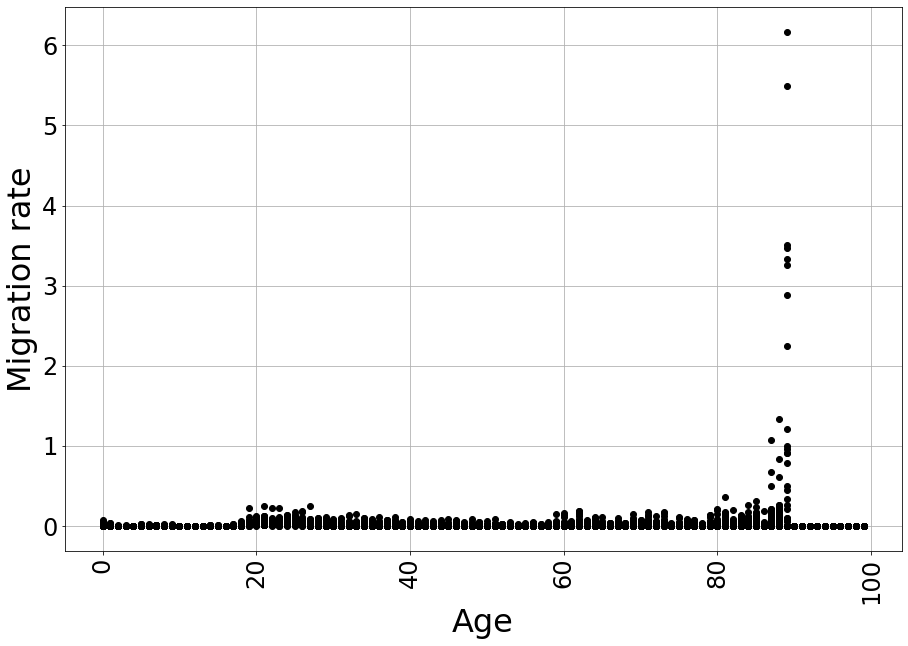

In [14]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_emigration["age_start"], 
         asfr_data_emigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Migration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

## Setup a simulation and run for `num_days`

In [ ]:
sim_start = time.time()

simulation.setup()
num_days = 365*1 + 10
simulation.run_for(duration=pd.Timedelta(days=num_days))



sim_end = time.time()

In [ ]:
pop = simulation.get_population()

print(f"Total time: {sim_end - sim_start}")
print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
print (f'#dead: {len(pop[pop["alive"]!="alive"])}')
try:
    print (f'#new borns: {len(pop[pop["parent_id"]!=-1])}')
except Exception:
    print("Fertility component should be activated to print new borns!")

In [ ]:
pop["cause_of_migration"].value_counts()

In [ ]:
pop["cause_of_death"].value_counts()

## Plot results

In [ ]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2012-12-31", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

In [ ]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

# Population (total, for selected ethnicities, gender)
total_population = len(pop)
total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
total_population_male = len(pop[pop["sex"] == 1])
total_population_female = len(pop[pop["sex"] == 2])

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    num_dead_population = total_population - len(pop_dead)
    population_axis.append(num_dead_population)
    
    num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(num_dead_population_eth)
    
    num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(num_dead_male)
    
    num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(num_dead_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [ ]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

In [ ]:
# Population (ethnicity)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_ETH_axis, 
         c='k', lw=4, marker="o", 
         label=sel_ethnicity
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [ ]:
# only dead population
pop_dead = pop[pop["alive"] != "alive"]

In [ ]:
series2plot = pop_dead['ethnicity'].value_counts() / len(pop_dead["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

In [ ]:
series2plot = pop_dead['sex'].value_counts() / len(pop_dead["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

pop_dead["exit_time"].hist(bins=20, 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

pop_dead["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

pop_dead["location"].hist(bins=100, 
                          rwidth=0.9, 
                          color='k',
                          align="left"
                         )
plt.xlabel("Location", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

# Fetility

In [ ]:
pop_births = pop[pop['parent_id']!= -1]

## Ethnicity of new births

In [ ]:
series2plot_births = pop_births['ethnicity'].value_counts() / len(pop_births["ethnicity"]) * 100.
indx = range(len(series2plot_births))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot_births, color='k')

plt.xticks(indx, series2plot_births.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

pop_births["entrance_time"].hist(bins=20, 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Born babies", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

## Age of mothers

In [ ]:
plt.figure(figsize=(15, 10))

pop.iloc[pop_births["parent_id"]]["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Frequency", size=32)
plt.xticks(size=24)
plt.yticks(size=24)

#plt.legend(fontsize=24)
plt.show()